# Objective: Create Lasso and Ridge Models Targeting 3DA 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Import Cricket Data
data = pd.read_csv("Data/WCD_TeamS_Cricket.csv")

In [5]:
# Check data
data.head()

,Team,Player,Leg Code,Game,3DA,W/A,TrueDate,Season_Day,TeamSeason,TeamAvg,Wins
0,Yavin 4,Daniel Pantis,8.2,Cricket,1.4,0,3/5/18,49,Yavin 46,1.673148,0
1,Yavin 4,Daniel Pantis,8.1,Cricket,1.8,0,3/5/18,49,Yavin 46,1.673148,0
2,Yavin 4,Johnathan Hoffman,8.3,Cricket,1.8,0,2/5/18,21,Yavin 46,1.673148,0
3,Yavin 4,Tony Christiansen,8.3,Cricket,1.9,0,3/19/18,63,Yavin 46,1.673148,0
4,Yavin 4,Johnathan Hoffman,8.2,Cricket,1.6,0,2/5/18,21,Yavin 46,1.673148,0


In [6]:
# Borrowed function for TeamSeason 3DA Deviation Feature
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature

In [7]:
# Get Team Season 3DA Deviation
add_deviation_feature(data,'3DA','TeamSeason')

In [8]:
# Check deviation values
data.head()

,Team,Player,Leg Code,Game,3DA,W/A,TrueDate,Season_Day,TeamSeason,TeamAvg,Wins,3DA_Dev_TeamSeason
0,Yavin 4,Daniel Pantis,8.2,Cricket,1.4,0,3/5/18,49,Yavin 46,1.673148,0,-0.608336
1,Yavin 4,Daniel Pantis,8.1,Cricket,1.8,0,3/5/18,49,Yavin 46,1.673148,0,0.282515
2,Yavin 4,Johnathan Hoffman,8.3,Cricket,1.8,0,2/5/18,21,Yavin 46,1.673148,0,0.282515
3,Yavin 4,Tony Christiansen,8.3,Cricket,1.9,0,3/19/18,63,Yavin 46,1.673148,0,0.505228
4,Yavin 4,Johnathan Hoffman,8.2,Cricket,1.6,0,2/5/18,21,Yavin 46,1.673148,0,-0.162910


In [10]:
# Check correlations in data
data = data.loc[:,['TeamSeason','Season_Day','Leg Code', '3DA', 'Wins','TeamAvg','3DA_Dev_TeamSeason']]
data.corr()

,Season_Day,Leg Code,3DA,Wins,TeamAvg,3DA_Dev_TeamSeason
Season_Day,1.000000,-0.036156,0.029655,-0.000045,1.783406e-02,1.805509e-02
Leg Code,-0.036156,1.000000,0.076738,0.000012,-2.524114e-04,9.457901e-02
3DA,0.029655,0.076738,1.000000,0.376032,5.157884e-01,8.262537e-01
Wins,-0.000045,0.000012,0.376032,1.000000,9.617056e-02,3.791924e-01
TeamAvg,0.017834,-0.000252,0.515788,0.096171,1.000000e+00,1.486506e-07
3DA_Dev_TeamSeason,0.018055,0.094579,0.826254,0.379192,1.486506e-07,1.000000e+00


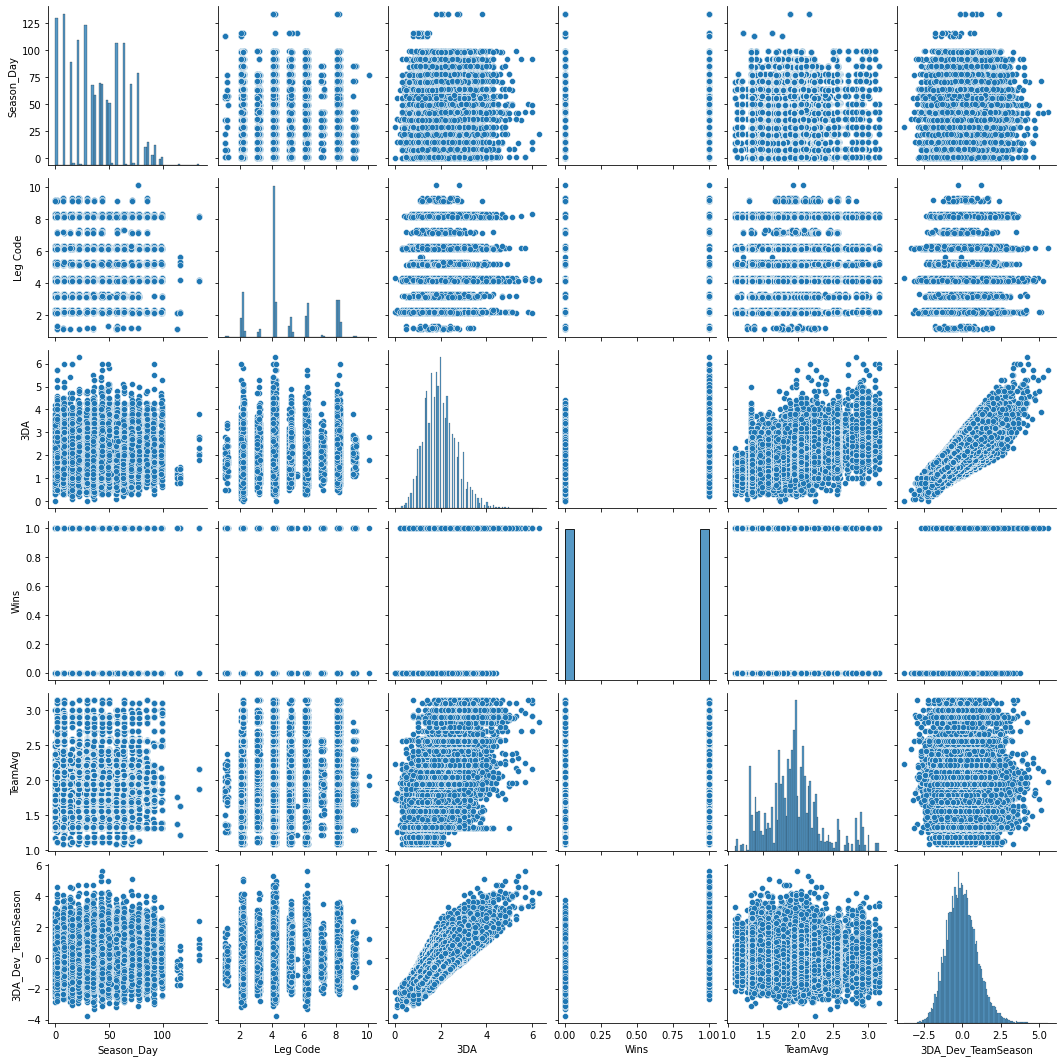

In [11]:
# Visualize correlations using pairplot
sns.pairplot(data)
plt.savefig('CricketPairPlot.png')

In [316]:
# Define target and features
X = data.loc[:,['Season_Day','Wins','TeamAvg','3DA_Dev_TeamSeason']]
y = data['3DA']

In [317]:
# Borrowed function for split and validate
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [318]:
# Use function on current features/target
split_and_validate(X, y)


Validation R^2 score was: 0.9456837168051493
Feature coefficient results: 

Season_Day : 0.00
Wins : 0.02
TeamAvg : 0.90
3DA_Dev_TeamSeason : 0.58


## Improve features' R^2 performance

In [313]:
# Leave original features as they are
X2 = X.copy()

In [314]:
# Add Set and Leg# Features, Try 3rd order for Season Day 
X2['SDExp'] = (X2['Season_Day']+50)**5
X2['TAvg2'] = (X2['TeamAvg']*100)**2
X2['Set'] = np.floor(X2['Leg Code'])
X2['Leg#'] = (X2['Leg Code']-X2['Set'])*10

In [319]:
# Check new features R^2
split_and_validate(X2, y)


Validation R^2 score was: 0.948449088078593
Feature coefficient results: 

Season_Day : -0.00
Leg Code : 0.00
Wins : 0.02
TeamAvg : 0.31
3DA_Dev_TeamSeason : 0.58
SDExp : 0.00
TAvg2 : 0.00
Set : 0.00
Leg# : 0.00


### Linear Regression

In [327]:
#Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X2, y, test_size=0.2, random_state=42)

In [328]:
#Define features
featureset = ['Season_Day','Leg Code', 'Wins','TeamAvg',
              '3DA_Dev_TeamSeason','SDExp','TAvg2','Set','Leg#']

In [329]:
#Instantiate and run linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.9521086541013709

In [351]:
#List of coefficients
lr_coefs = list(zip(featureset, lr.coef_))
lr_coefs

[('Season_Day', -0.0003218512189103698),
 ('Leg Code', 0.0002911116879352237),
 ('Wins', 0.02024520003447243),
 ('TeamAvg', 0.31398016577764315),
 ('3DA_Dev_TeamSeason', 0.5799782509985785),
 ('SDExp', 9.139321489216836e-13),
 ('TAvg2', 1.4231527415652655e-05),
 ('Set', 9.556700785929831e-05),
 ('Leg#', 0.0019554278759833597)]

## Lasso

In [ ]:
#Standardize
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [337]:
# Range for alpha values
alphavec = 10**np.linspace(-6,1,2000)

In [338]:
# Alpha CV to find best value
lasso_cricket = LassoCV(alphas = alphavec, cv=5)
lasso_cricket.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.00809567e-06, 1.01625689e-06, ...,
       9.84003172e+00, 9.91969340e+00, 1.00000000e+01]),
        cv=5)

In [339]:
# Get the alpha value
lasso_cricket.alpha_

3.230387546231894e-05

In [340]:
# Lasso with that alpha
lc = Lasso(alpha = 3.230387546231894e-05)
lc.fit(X_tr, y_train)

Lasso(alpha=3.230387546231894e-05)

In [341]:
# Coefficient list
lc_coefs = list(zip(featureset, lasso_cricket.coef_))
lc_coefs

[('Season_Day', -0.00801114321973004),
 ('Leg Code', 0.0007258974844664381),
 ('Wins', 0.010100843661652663),
 ('TeamAvg', 0.12524161971762368),
 ('3DA_Dev_TeamSeason', 0.5765007582917665),
 ('SDExp', 0.013107347978038085),
 ('TAvg2', 0.23781708616470096),
 ('Set', 0.0),
 ('Leg#', 0.001329135308390931)]

In [342]:
# Train score
lc.score(X_tr, y_train)

0.952108613201335

In [343]:
# Test score
lc.score(X_te, y_test)

0.9484481034808311

## Ridge

In [344]:
#Define alpha vector for ridge
alphavec = 10**np.linspace(0,10,200)

In [345]:
#Use Ridge CV
ridge_cricket = RidgeCV(alphas = alphavec, cv=5)
ridge_cricket.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12266777e+00, 1.26038293e+00, 1.41499130e+00,
       1.58856513e+00, 1.78343088e+00, 2.00220037e+00, 2.24780583e+00,
       2.52353917e+00, 2.83309610e+00, 3.18062569e+00, 3.57078596e+00,
       4.00880633e+00, 4.50055768e+00, 5.05263107e+00, 5.67242607e+00,
       6.36824994e+00, 7.14942899e+00, 8.02643352e+00, 9.01101825e+00,
       1.01163798e+01, 1.13573336e+0...
       6.98587975e+08, 7.84282206e+08, 8.80488358e+08, 9.88495905e+08,
       1.10975250e+09, 1.24588336e+09, 1.39871310e+09, 1.57029012e+09,
       1.76291412e+09, 1.97916687e+09, 2.22194686e+09, 2.49450814e+09,
       2.80050389e+09, 3.14403547e+09, 3.52970730e+09, 3.96268864e+09,
       4.44878283e+09, 4.99450512e+09, 5.60716994e+09, 6.29498899e+09,
       7.06718127e+09, 7.93409667e+09, 8.90735464e+09, 1.00000000e+10]),
        cv=5)

In [346]:
#Alpha from ridge CV
ridge_cricket.alpha_

9.011018251665021

In [347]:
#Run Ridge with Alpha
rc = Ridge(alpha = 9.011018251665021)
rc.fit(X_tr, y_train)

Ridge(alpha=9.011018251665021)

In [348]:
#List Ridge coefficients
rc_coefs = list(zip(featureset, rc.coef_))
rc_coefs

[('Season_Day', -0.008226889910773248),
 ('Leg Code', 0.000413192484475537),
 ('Wins', 0.010214461459690146),
 ('TeamAvg', 0.1271824014371239),
 ('3DA_Dev_TeamSeason', 0.5762842005530271),
 ('SDExp', 0.013334738666363682),
 ('TAvg2', 0.2358311614807432),
 ('Set', 0.0003638028558918035),
 ('Leg#', 0.0013837107354869942)]

In [349]:
#Ridge Train score
rc.score(X_tr, y_train)

0.952108401704828

In [350]:
#Ridge Test score
rc.score(X_te, y_test)

0.9484481535056174